In [25]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sma

In [2]:
data_root = Path(r"D:\git\statistics\utils\data\propensity_score")
data_root

WindowsPath('D:/git/statistics/utils/data/propensity_score')

In [5]:
df_path = data_root/"all_valid_data.csv"
df = pd.read_csv(df_path)
df

,filename,ID,LR,age,sex,is_ptosis
0,1000013L.jpg,1000013,L,84,M,0
1,1000013R.jpg,1000013,R,84,M,0
2,1000305_20171128_105400_n_L.jpg,1000305,L,68,F,1
3,1000305_20171128_105400_n_R.jpg,1000305,R,68,F,1
4,1000305_20180307_153040_n_L.jpg,1000305,L,68,F,0
...,...,...,...,...,...,...
1514,540318_20180202_134156_n_R.jpg,540318,R,82,F,0
1515,563320_20180611_102215_n_L.jpg,563320,L,51,F,1
1516,563320_20180611_102215_n_R.jpg,563320,R,51,F,1
1517,563320_20180626_161455_n_L.jpg,563320,L,51,F,0


In [8]:
X_cols = ["LR", "age", "sex"]
Z_col = ["is_ptosis"]

X = df[X_cols].copy()
Z = df[Z_col].copy()
X

,LR,age,sex
0,L,84,M
1,R,84,M
2,L,68,F
3,R,68,F
4,L,68,F
...,...,...,...
1514,R,82,F
1515,L,51,F
1516,R,51,F
1517,L,51,F


In [10]:
X = pd.get_dummies(X)[["age", "LR_L", "sex_F"]]
X

,age,LR_L,sex_F
0,84,1,0
1,84,0,0
2,68,1,1
3,68,0,1
4,68,1,1
...,...,...,...
1514,82,0,1
1515,51,1,1
1516,51,0,1
1517,51,1,1


In [11]:
X.describe()

,age,LR_L,sex_F
count,1519.000000,1519.000000,1519.000000
mean,71.352864,0.499671,0.541145
std,9.591967,0.500165,0.498468
min,22.000000,0.000000,0.000000
25%,67.000000,0.000000,0.000000
50%,72.000000,0.000000,1.000000
75%,77.000000,1.000000,1.000000
max,100.000000,1.000000,1.000000


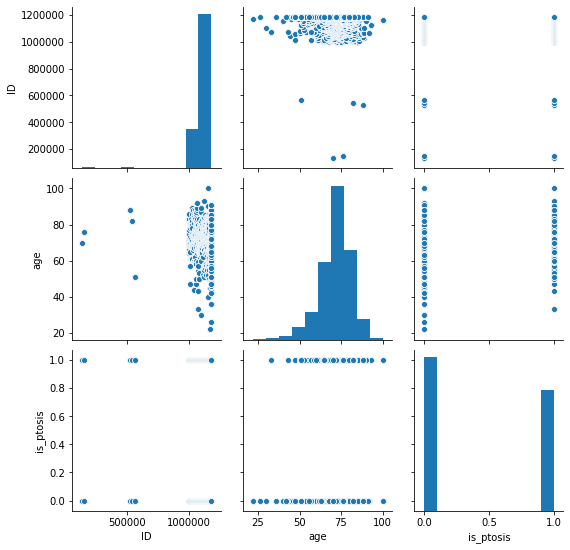

In [16]:
sns.pairplot(df)

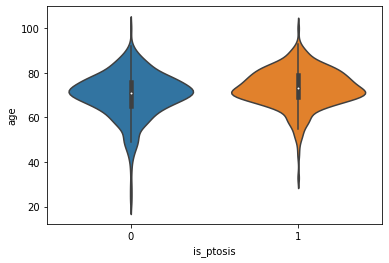

In [21]:
sns.violinplot(df["is_ptosis"], df["age"])

In [38]:
over60_df = df.loc[df["age"]>80]
over60_df

,filename,ID,LR,age,sex,is_ptosis
0,1000013L.jpg,1000013,L,84,M,0
1,1000013R.jpg,1000013,R,84,M,0
6,1000811L.jpg,1000811,L,85,F,1
7,1000811R.jpg,1000811,R,85,F,1
16,1003075L.jpg,1003075,L,83,F,0
...,...,...,...,...,...,...
1510,526279_20180601_093638_n_R.jpg,526279,R,88,F,0
1511,540318_20180117_154324_n_L.jpg,540318,L,82,F,1
1512,540318_20180117_154324_n_R.jpg,540318,R,82,F,1
1513,540318_20180202_134156_n_L.jpg,540318,L,82,F,0


In [39]:
def make_demographic(df, group_col, **kwargs):
    """
    stackしたデータから独立な2群(group_col)に分けてdemographic dataを作成する
    **kwargs:比較したい性別や年齢などを指定。変数名="c" or "m" のモードに対応
    LR="c", sex="c", age="m"のように指定し、モードcは**％(**/**)、mは平均±SDを出力
    """
    res_df = pd.DataFrame(columns=kwargs.keys())
    for param, func in kwargs.items():
        if func == "c":
            piv = pd.crosstab(df[param], df[group_col], margins=True)
            x2, p, dof, e = st.chi2_contingency(piv, correction=False)
            
            rates = [round(piv.iloc[0, i] / piv.iloc[2, i] * 100, 1) for i in range(2)]
            row = {}
            for i in range(2):
                row[piv.columns[i]] = "{0}%({1}/{2})".format(rates[i], piv.iloc[0, i], piv.iloc[2, i])
            row["p value"] = p.round(2) if p >= 0.01 else "p<0.01"
            res_df[param] = pd.Series(row)
            
        elif func == "m":
            piv = df.pivot_table(values=param, columns=group_col, aggfunc=["mean", "std"])
            means = [round(piv.iloc[0, i], 1) for i in range(2)]
            stds = [round(piv.iloc[0, i+2], 1) for i in range(2)]
            
            row = {}
            for i in range(2):
                row[piv.columns[i][1]] = "{0}±{1}".format(means[i], stds[i])
            A = [df[df[group_col]==piv.columns[i][1]][param] for i in range(2)]
            p = st.ttest_ind(*A, equal_var=False).pvalue
            row["p value"] = p.round(2) if p >= 0.01 else "p<0.01"
            res_df[param] = pd.Series(row)
        
    return res_df.T

In [40]:
make_demographic(over60_df, "is_ptosis", age="m", LR="c", sex="c")

,0,1,p value
age,84.8±3.6,84.5±3.6,0.61
LR,50.0%(52/104),50.0%(63/126),1
sex,61.5%(64/104),60.3%(76/126),1


In [43]:
#傾向スコアを求める
glm = sma.Logit(Z, X)
result = glm.fit()
ps = pd.Series(result.predict(X))
ps

Optimization terminated successfully.
         Current function value: 0.688095
         Iterations 4


0       0.438509
1       0.461330
2       0.438003
3       0.460819
4       0.438003
          ...   
1514    0.454408
1515    0.445738
1516    0.468621
1517    0.445738
1518    0.468621
Length: 1519, dtype: float64

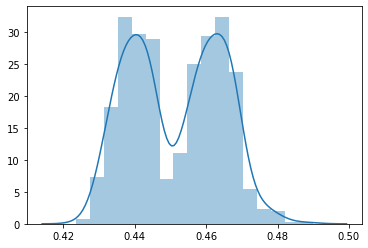

In [44]:
sns.distplot(ps)

In [47]:
prop_Z_df = pd.concat([ps, Z], axis=1).rename(columns={0: "prop"})
prop_Z_df

,prop,is_ptosis
0,0.438509,0
1,0.461330,0
2,0.438003,1
3,0.460819,1
4,0.438003,0
...,...,...
1514,0.454408,0
1515,0.445738,1
1516,0.468621,1
1517,0.445738,0


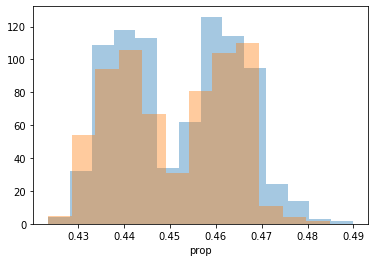

In [50]:
sns.distplot(prop_Z_df[prop_Z_df["is_ptosis"]==0]["prop"], kde=False)
sns.distplot(prop_Z_df[prop_Z_df["is_ptosis"]==1]["prop"], kde=False)

In [51]:
prop_Z_X_df = pd.concat([prop_Z_df, X], axis=1)
prop_Z_X_df

,prop,is_ptosis,age,LR_L,sex_F
0,0.438509,0,84,1,0
1,0.461330,0,84,0,0
2,0.438003,1,68,1,1
3,0.460819,1,68,0,1
4,0.438003,0,68,1,1
...,...,...,...,...,...
1514,0.454408,0,82,0,1
1515,0.445738,1,51,1,1
1516,0.468621,1,51,0,1
1517,0.445738,0,51,1,1


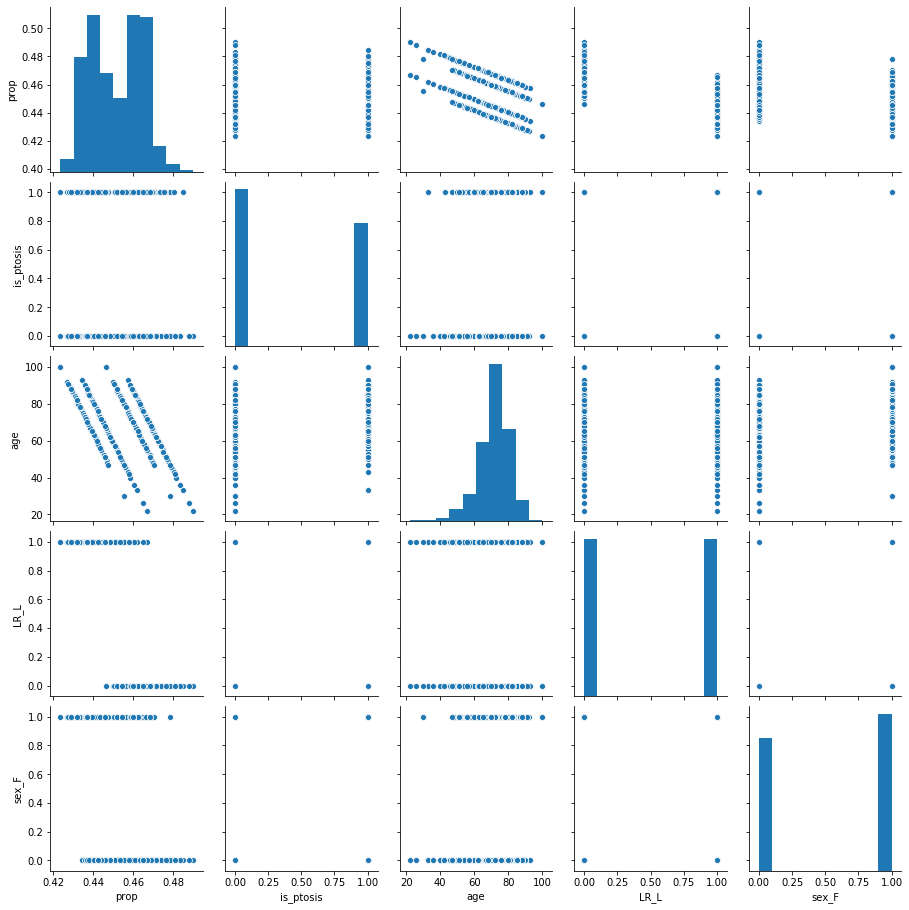

In [52]:
sns.pairplot(prop_Z_X_df)

In [53]:
Z_X_df = pd.concat([Z, X], axis=1)
Z_X_df

,is_ptosis,age,LR_L,sex_F
0,0,84,1,0
1,0,84,0,0
2,1,68,1,1
3,1,68,0,1
4,0,68,1,1
...,...,...,...,...
1514,0,82,0,1
1515,1,51,1,1
1516,1,51,0,1
1517,0,51,1,1


In [54]:
df

,filename,ID,LR,age,sex,is_ptosis
0,1000013L.jpg,1000013,L,84,M,0
1,1000013R.jpg,1000013,R,84,M,0
2,1000305_20171128_105400_n_L.jpg,1000305,L,68,F,1
3,1000305_20171128_105400_n_R.jpg,1000305,R,68,F,1
4,1000305_20180307_153040_n_L.jpg,1000305,L,68,F,0
...,...,...,...,...,...,...
1514,540318_20180202_134156_n_R.jpg,540318,R,82,F,0
1515,563320_20180611_102215_n_L.jpg,563320,L,51,F,1
1516,563320_20180611_102215_n_R.jpg,563320,R,51,F,1
1517,563320_20180626_161455_n_L.jpg,563320,L,51,F,0


In [59]:
df["LR_L"] = pd.get_dummies(df["LR"])["L"]
df["sex_F"] = pd.get_dummies(df["sex"])["F"]
df

,filename,ID,LR,age,sex,is_ptosis,LR_L,sex_F
0,1000013L.jpg,1000013,L,84,M,0,1,0
1,1000013R.jpg,1000013,R,84,M,0,0,0
2,1000305_20171128_105400_n_L.jpg,1000305,L,68,F,1,1,1
3,1000305_20171128_105400_n_R.jpg,1000305,R,68,F,1,0,1
4,1000305_20180307_153040_n_L.jpg,1000305,L,68,F,0,1,1
...,...,...,...,...,...,...,...,...
1514,540318_20180202_134156_n_R.jpg,540318,R,82,F,0,0,1
1515,563320_20180611_102215_n_L.jpg,563320,L,51,F,1,1,1
1516,563320_20180611_102215_n_R.jpg,563320,R,51,F,1,0,1
1517,563320_20180626_161455_n_L.jpg,563320,L,51,F,0,1,1


In [62]:
ptosis_df = df.loc[df["is_ptosis"]==1]
non_ptosis_df = df.loc[df["is_ptosis"]==0]
#make_demographic(df, "is_ptosis", age="m", LR="c", sex="c")

In [63]:
ptosis_df

,filename,ID,LR,age,sex,is_ptosis,LR_L,sex_F
2,1000305_20171128_105400_n_L.jpg,1000305,L,68,F,1,1,1
3,1000305_20171128_105400_n_R.jpg,1000305,R,68,F,1,0,1
6,1000811L.jpg,1000811,L,85,F,1,1,1
7,1000811R.jpg,1000811,R,85,F,1,0,1
8,1000891L.jpg,1000891,L,75,F,1,1,1
...,...,...,...,...,...,...,...,...
1508,526279_20180417_110816_n_R.jpg,526279,R,88,F,1,0,1
1511,540318_20180117_154324_n_L.jpg,540318,L,82,F,1,1,1
1512,540318_20180117_154324_n_R.jpg,540318,R,82,F,1,0,1
1515,563320_20180611_102215_n_L.jpg,563320,L,51,F,1,1,1


In [64]:
non_ptosis_df

,filename,ID,LR,age,sex,is_ptosis,LR_L,sex_F
0,1000013L.jpg,1000013,L,84,M,0,1,0
1,1000013R.jpg,1000013,R,84,M,0,0,0
4,1000305_20180307_153040_n_L.jpg,1000305,L,68,F,0,1,1
5,1000305_20180307_153040_n_R.jpg,1000305,R,68,F,0,0,1
14,1002415_20180727_113027_n_L.jpg,1002415,L,70,F,0,1,1
...,...,...,...,...,...,...,...,...
1510,526279_20180601_093638_n_R.jpg,526279,R,88,F,0,0,1
1513,540318_20180202_134156_n_L.jpg,540318,L,82,F,0,1,1
1514,540318_20180202_134156_n_R.jpg,540318,R,82,F,0,0,1
1517,563320_20180626_161455_n_L.jpg,563320,L,51,F,0,1,1


In [65]:
non_ptosis_df.sample(669)

,filename,ID,LR,age,sex,is_ptosis,LR_L,sex_F
1081,1181404L.jpg,1181404,L,56,M,0,1,0
1268,1182475R.jpg,1182475,R,68,F,0,0,1
100,1028376L.jpg,1028376,L,75,M,0,1,0
1260,1182428R.jpg,1182428,R,74,F,0,0,1
1374,1183524R.jpg,1183524,R,47,F,0,0,1
...,...,...,...,...,...,...,...,...
1271,1182515L.jpg,1182515,L,64,F,0,1,1
1436,1184428R.jpg,1184428,R,80,F,0,0,1
571,1130190R.jpg,1130190,R,75,M,0,0,0
640,1142613L.jpg,1142613,L,73,F,0,1,1


In [75]:
def get_pvalue(ptosis_df, non_ptosis_df):
    tmp_df = pd.concat([ptosis_df, non_ptosis_df])
    return make_demographic(tmp_df, "is_ptosis", age="m")["p value"][0]

In [70]:
import sys
sys.version

'3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]'

In [121]:
n = 669
tmp = ptosis_df.sample(n)
non_tmp = non_ptosis_df.sample(n)
p = get_pvalue(ptosis_df, non_tmp)
cnt = 0
while p == 'p<0.01' or p < 0.06:
    tmp = ptosis_df.sample(n)
    non_tmp = non_ptosis_df.sample(n)
    p = get_pvalue(tmp, non_tmp)
    n -= 1
    if n <= 361:
        break
    
display(non_tmp)
print(p)

,filename,ID,LR,age,sex,is_ptosis,LR_L,sex_F
1010,1178997R.jpg,1178997,R,65,F,0,0,1
959,1173544L.jpg,1173544,L,73,M,0,1,0
507,1120861R.jpg,1120861,R,76,M,0,0,0
330,1084972L.jpg,1084972,L,76,F,0,1,1
1121,1181745L.jpg,1181745,L,59,M,0,1,0
...,...,...,...,...,...,...,...,...
194,1060669L.jpg,1060669,L,87,F,0,1,1
1079,1181396L.jpg,1181396,L,68,M,0,1,0
1219,1182185L.jpg,1182185,L,69,M,0,1,0
779,1157262_20180425_110812_n_R.jpg,1157262,R,76,F,0,0,1


p<0.01


In [113]:
best_tmp = tmp.copy()
best_non = non_tmp.copy()
print(len(best_non)*2)
best_df = pd.concat([best_tmp, best_non])
make_demographic(best_df, "is_ptosis", age="m", LR="c", sex="c")

722


,0,1,p value
age,71.6±9.7,72.8±8.8,0.08
LR,47.1%(170/361),49.9%(180/361),0.97
sex,50.7%(183/361),52.9%(191/361),0.99


In [123]:
from tqdm import tqdm

min_n = 100
for i in tqdm(range(500)):
    for n in range(669, min_n, -1):
        tmp = ptosis_df.sample(n)
        non_tmp = non_ptosis_df.sample(n)
        p = get_pvalue(tmp, non_tmp)

        if not(p == 'p<0.01' or p < 0.06):
            now_tmp = tmp
            now_non = non_tmp
            now_p = p
            min_n = n
            print(n, p)
            break

  0%|▏                                                                                 | 1/500 [00:05<49:29,  5.95s/it]

248 0.08


  1%|█▏                                                                                | 7/500 [00:40<46:44,  5.69s/it]

303 0.07


  2%|█▎                                                                                | 8/500 [00:45<45:16,  5.52s/it]

306 0.24


  3%|██▌                                                                              | 16/500 [01:26<40:31,  5.02s/it]

332 0.26


  6%|█████                                                                            | 31/500 [02:37<37:10,  4.76s/it]

335 0.06


 45%|████████████████████████████████████▎                                           | 227/500 [18:23<21:20,  4.69s/it]

371 0.06


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [38:09<00:00,  4.58s/it]


In [124]:
_best_tmp = now_tmp.copy()
_best_non = now_non.copy()
print(len(_best_non)*2)
_best_df = pd.concat([_best_tmp, _best_non])
make_demographic(_best_df, "is_ptosis", age="m", LR="c", sex="c")

742


,0,1,p value
age,71.0±10.3,72.3±8.9,0.06
LR,50.1%(186/371),49.1%(182/371),1
sex,55.0%(204/371),54.2%(201/371),1


In [126]:
_best_df.to_csv("adjusted.csv")